# NLP EDA

Basically, exploration and modeling boil down to a single question:

How do we quantify our data/text

In this lesson, we'll explore answers to this question that will aid in visualization.

- word frequency (by label)
- ngrams
- word cloud
- sentiment analysis
- other common features

## Setup

Data is spam/ham text messages.

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import unicodedata
import re

In [68]:
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

In [122]:
def clean(col, extra_words=[], exclude_words=[]):
    bc = [prepare.basic_clean(entry) for entry in col]   
    t = [prepare.tokenize(entry) for entry in bc]
    # if method == 'lemmatize':
    #     l = [lemmatize(entry) for entry in t]
    return [prepare.remove_stopwords(entry, extra_words, exclude_words) for entry in t]
    # if method == 'stemming':
    #     s = [stem(entry) for entry in t]
        # return [remove_stopwords(entry, extra_words, exclude_words) for entry in s]

In [103]:
# # basic cleaning function:
# def clean(text):
#     '''Simplified text cleaning function'''
#     stopwords = nltk.corpus.stopwords.words('english')
#     text = text.lower()
#     text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
#     words = re.sub(r"[^a-z0-9\s]", '', text)
#     return ''.join([word for word in words if word not in stopwords])

In [104]:
# acquire data from spam_db

from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [105]:
'***'.join(['this', 'is', 'a', 'list of strings'])

'this***is***a***list of strings'

In [133]:
ham_words = ' '.join(clean(df[df.label == 'ham']['text'], extra_words = ['\'', 'u', '2', 'ltgt']))
spam_words = ' '.join(clean(df[df.label == 'spam']['text'], extra_words = ['\'', 'u', '2', 'ltgt']))
all_words = ' '.join(clean(df['text'], extra_words = ['\'', 'u', '2', 'ltgt']))

In [134]:
len(all_words), len(ham_words), len(spam_words)

(294383, 214692, 79690)

## Exploration

Represent text as word frequencies.

In [135]:
ham_freq = pd.Series(ham_words.split()).value_counts()
spam_freq = pd.Series(spam_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [136]:
ham_freq.head()

get     303
ok      272
go      247
ur      240
know    232
dtype: int64

In [137]:
# concat all frequencies together into a dataframe
word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['ham', 'spam', 'all']
word_counts

,ham,spam,all
get,303,83,386
ok,272,5,277
go,247,31,278
ur,240,144,384
know,232,25,257
...,...,...,...
skillgame1winaweek,0,1,1
yohere,0,1,1
themobyo,0,1,1
09061743810,0,1,1


- What are the most frequently occuring words?
- Are there any words that uniquely identify a spam or ham message? I.e. words present in one type of message but not the other?

In [138]:
# sort by 'all'
word_counts.sort_values('all', ascending=False).head()

,ham,spam,all
call,229,347,576
get,303,83,386
ur,240,144,384
4,169,119,288
go,247,31,278


In [139]:
# sort by 'ham' and 'spam' columns
word_counts.sort_values('ham', ascending=False).head()

,ham,spam,all
get,303,83,386
ok,272,5,277
go,247,31,278
ur,240,144,384
know,232,25,257


In [140]:
word_counts.sort_values('spam', ascending=False).head()

,ham,spam,all
call,229,347,576
free,59,216,275
txt,13,150,163
ur,240,144,384
mobile,15,123,138


### Visualization

- ham vs spam count for 20 most common words
- ham vs spam proportion for 20 most common words

In [141]:
plt.rc('font', size=18)


Text(0.5, 1.0, '% of spam vs ham for the most common 20 words')

<Figure size 1152x648 with 0 Axes>

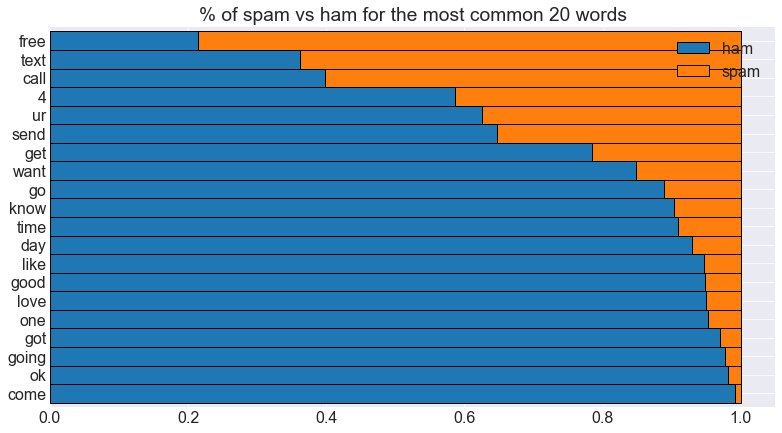

In [142]:
plt.figure(figsize=(16, 9))
plt.rc('font', size=16)

(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'spam')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.title('% of spam vs ham for the most common 20 words')

## n-grams

**bigram**: combinations of 2 words

Represent text as combinations of 2 words

In [143]:
sentence = 'Today is tuesday, and the weather is nice.'

In [147]:
list(nltk.bigrams(sentence.split()))

[('Today', 'is'),
 ('is', 'tuesday,'),
 ('tuesday,', 'and'),
 ('and', 'the'),
 ('the', 'weather'),
 ('weather', 'is'),
 ('is', 'nice.')]

**Be Careful!** Make sure you are making bigrams out of *words*.

In [152]:
# spam_words = spam_words.split()
# spam_words

In [154]:
list(nltk.ngrams(sentence.split(), 3))

[('Today', 'is', 'tuesday,'),
 ('is', 'tuesday,', 'and'),
 ('tuesday,', 'and', 'the'),
 ('and', 'the', 'weather'),
 ('the', 'weather', 'is'),
 ('weather', 'is', 'nice.')]

- what are the most common bigrams? spam bigrams? ham bigrams?
- visualize 20 most common bigrams, most common ham bigrams
- ngrams

Find the most common bigram and then find a representative text

<AxesSubplot:>

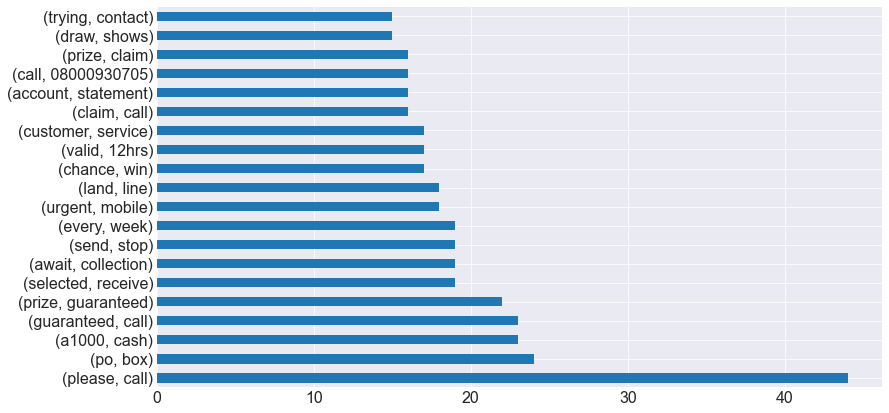

In [163]:
pd.Series(nltk.ngrams(spam_words, 2)).value_counts().head(20).plot.barh()

## Word Cloud

`python -m pip install --upgrade wordcloud`

documentation: https://amueller.github.io/word_cloud/

In [165]:
from wordcloud import WordCloud

In [176]:
pd.Series(ham_words.split()).value_counts().head()

get     303
ok      272
go      247
ur      240
know    232
dtype: int64

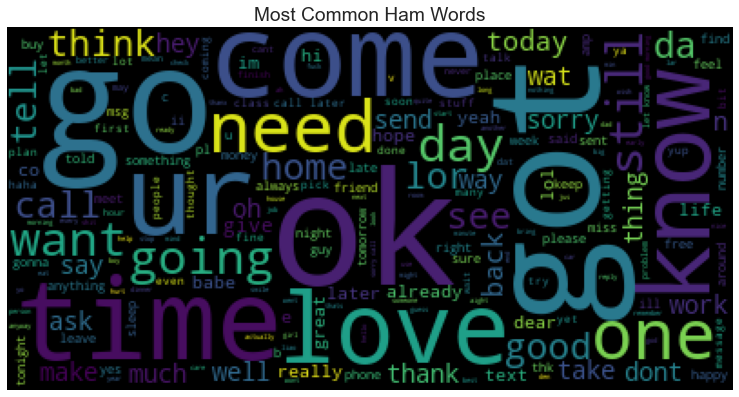

In [172]:
img = WordCloud().generate(ham_words)
plt.imshow(img)
plt.axis('off')
plt.title('Most Common Ham Words')
plt.show()

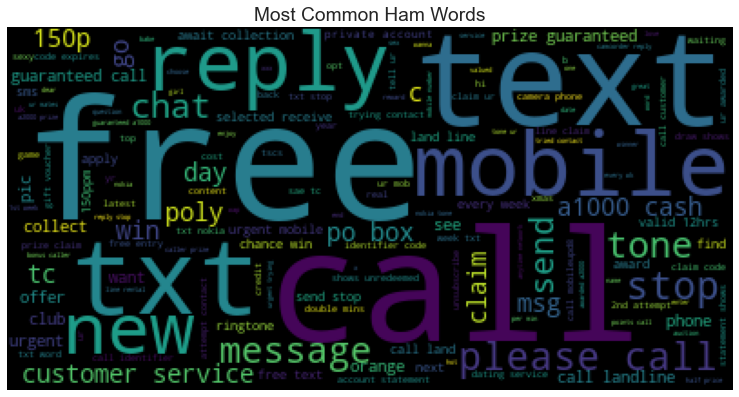

In [179]:
img = WordCloud().generate(' '.join(spam_words))
plt.imshow(img)
plt.axis('off')
plt.title('Most Common Ham Words')
plt.show()

## Other Common Features

Any NLP dataset will have domain specific features, for example: number of retweets, number of @mentions, number of upvotes, or mean time to respond to a support chat. In addition to these domain specific features, some common measures for a document are:

- character count
- word count
- sentence count
- stopword count
- unique word count
- punctuation count
- average word length
- average words per sentence
- word to stopword ratio

Create one or more of the above features and visualize it.

In [186]:
# add two new columns 'message_length' and 'word_count'

In [187]:
df['message_length'] = df['text'].str.len()

In [188]:
df.head()

,label,text,message_length
id,,,
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [194]:
df['word_count'] = df.text.apply(clean).apply(len)

## Sentiment

A number indicating whether the document is positive or negative.

- knowledge-based + statistical approach
- relies on human-labelled data
    - combination of qualitative and quantitative methods
    - then empirically validate
- different models for diff domains (e.g. social media vs news)
- for social media
    - Afinn ([github](https://github.com/fnielsen/afinn) + [whitepaper](http://www2.imm.dtu.dk/pubdb/edoc/imm6006.pdf))
    - Vader ([github](https://github.com/cjhutto/vaderSentiment) + [whitepaper](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf)) `nltk.sentiment.vader.SentimentIntensityAnalyzer`. Pre-trained sentiment analyzer (**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner).)


From your terminal:
`python -c 'import nltk;nltk.download("vader_lexicon")'`

In [196]:
import nltk.sentiment

sia = nltk.sentiment.SentimentIntensityAnalyzer()
sia.polarity_scores('He is really good')

{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'compound': 0.4927}

In [197]:
sia.polarity_scores('He is really good!!!')

{'neg': 0.0, 'neu': 0.424, 'pos': 0.576, 'compound': 0.6211}

In [198]:
sia.polarity_scores('He is REALLY good')

{'neg': 0.0, 'neu': 0.433, 'pos': 0.567, 'compound': 0.6028}

In [199]:
sia.polarity_scores('He is very good!!!')

{'neg': 0.0, 'neu': 0.424, 'pos': 0.576, 'compound': 0.6211}

In [200]:
sia.polarity_scores('The food is good but service is slow')

{'neg': 0.0, 'neu': 0.782, 'pos': 0.218, 'compound': 0.2382}

In [201]:
sia.polarity_scores('He is good :-)')

{'neg': 0.0, 'neu': 0.278, 'pos': 0.722, 'compound': 0.6369}

In [202]:
sia.polarity_scores('she is vegan :/')

{'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'compound': -0.34}

Things that can influence Sentiment Score:
1. Punctuations. Can increase the intensity
2. Capitalization. Can increase the intensity
3. Degree modifiers
4. Conjunctions

It can handle Emojis and slangs

Apply this to the text message data

In [203]:
df['sentiment'] = df.text.apply(lambda doc: sia.polarity_scores(doc)['compound'])
df

,label,text,message_length,word_count,sentiment
id,,,,,
0,ham,"Go until jurong point, crazy.. Available only ...",111,111,0.6249
1,ham,Ok lar... Joking wif u oni...,29,29,0.4767
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,155,0.7964
3,ham,U dun say so early hor... U c already then say...,49,49,0.0000
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,61,-0.1027
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,161,0.8805
5568,ham,Will Ì_ b going to esplanade fr home?,37,37,0.0000
5569,ham,"Pity, * was in mood for that. So...any other s...",57,57,-0.2960


In [204]:
# is the mean and median values of sentiment score different for ham vs spam?
df.groupby('label').sentiment.agg(['mean','median'])

,mean,median
label,,
ham,0.152218,0.0000
spam,0.436018,0.6107


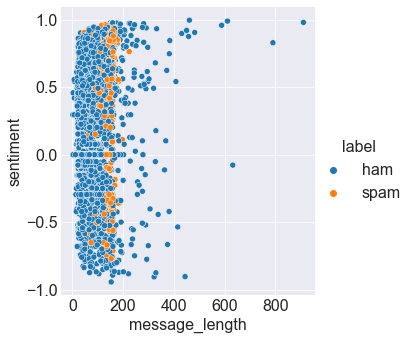

In [205]:
#plot message_length vs sentiment and hue by label
sns.relplot(data = df, x = 'message_length', y = 'sentiment', hue = 'label')

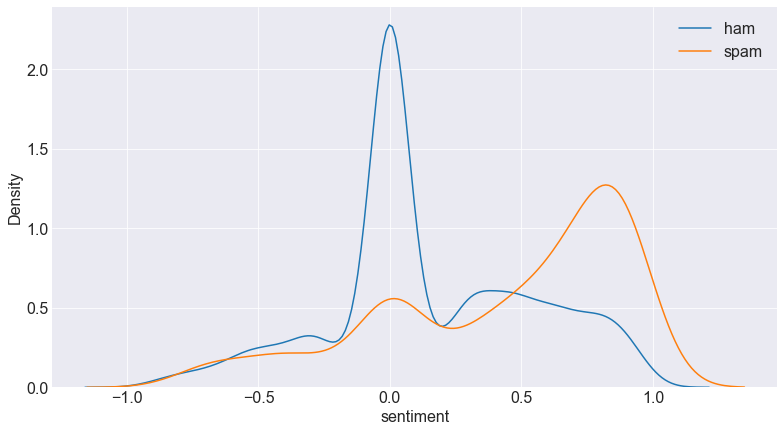

In [206]:
# is the distribution for sentiment different for ham vs spam
sns.kdeplot(df[df.label == 'ham'].sentiment, label = 'ham')
sns.kdeplot(df[df.label == 'spam'].sentiment, label = 'spam')
plt.legend(['ham', 'spam'])

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='message_length', ylabel='sentiment'>

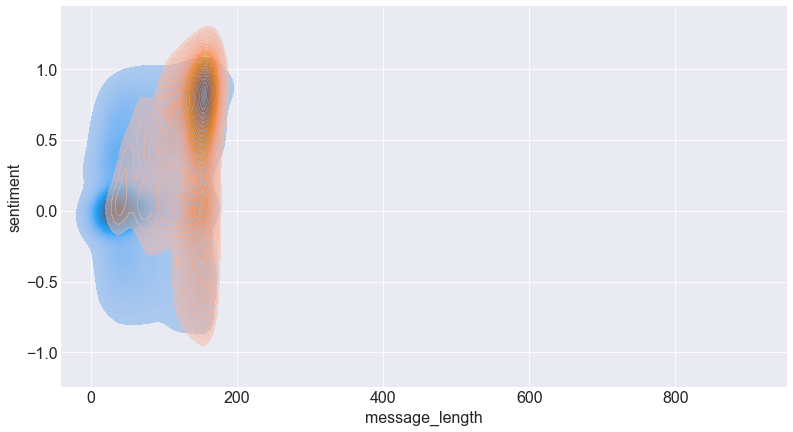

In [207]:
# Bivariate KDE plot for message_length vs sentiment score 
sns.kdeplot(df[df.label == 'ham'].message_length,df[df.label == 'ham'].sentiment, levels = 30, shade = True )
sns.kdeplot(df[df.label == 'spam'].message_length,df[df.label == 'spam'].sentiment, levels = 30, shade = True, alpha = 0.5 )

## More Resources

- [kaggle wikipedia movie plots](https://www.kaggle.com/jrobischon/wikipedia-movie-plots)
    - Suggestion: narrow to top n genres that aren't unknown
- [wikitable extractor](https://wikitable2csv.ggor.de/) (Try with, e.g. [helicopter prison escapes](https://en.wikipedia.org/wiki/List_of_helicopter_prison_escapes))
- [Textblob library](https://textblob.readthedocs.io/en/dev/)